In [2]:
import augmentations
import numpy as np
from custom_image_folder import CustomImageFolder
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize
import torch
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from copy import copy
import time
from PIL import Image

#splits the train data to train and validation sets
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    
    datasets['train'].dataset = copy(dataset)
    #these train and val basic augmentation are done at loading images 
    #it's data preprocessing don't modify it
    datasets['train'].dataset.transform = transforms.Compose([
    
    	transforms.ToTensor(),
    	transforms.Normalize(mean, std)
            ])
            
    datasets['val'].dataset.transform = transforms.Compose([
 		
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
            ])
    return datasets

#to see the dataset images 
def imshow(inp, title):
    """Imshow for Tensor."""
    
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

## Double Example

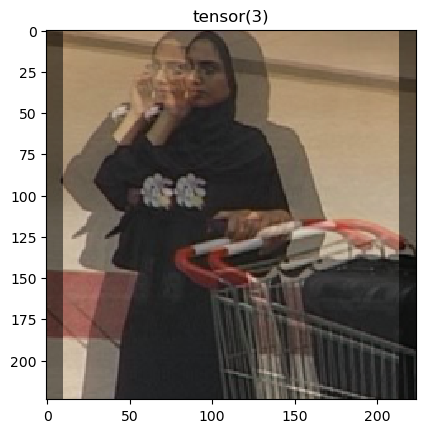

In [18]:
dataset = CustomImageFolder(
    'train_sub',
    {
        0: transforms.Compose([
            transforms.Resize((256,256)),
            transforms.CenterCrop(224),
            augmentations.Double(20), # Custom Double Augmentation
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }
)

# Gets separated data
image_datasets = train_val_dataset(dataset)

# Apply 0th epoch transform which has the custom double augmentation
image_datasets['train'].dataset.update_transform(0)

# Dataloader shuffles both train and valid!!! image_datasets
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=5,
        shuffle=True, 
        num_workers=2
    )
    for x in ['train','val']
}

# Full dataset size needed for training              
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

# Declaring the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for inputs, labels in dataloaders['train']:
    imshow(inputs[0], labels[0])
    break

## Mixup Example

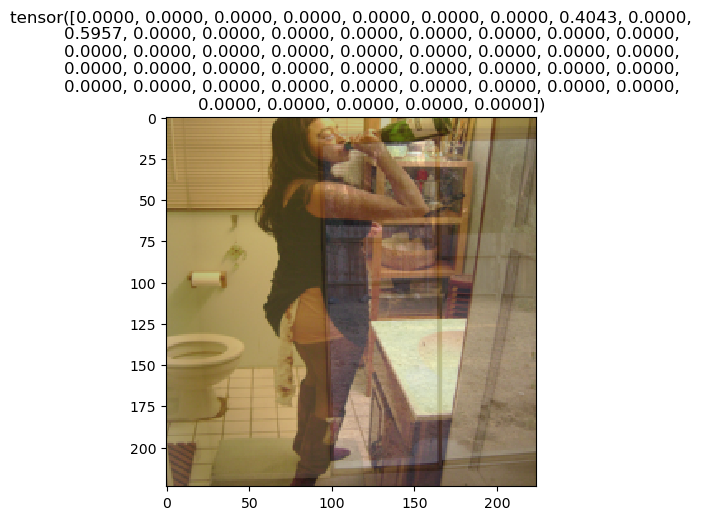

In [24]:
dataset = CustomImageFolder(
    'train_sub',
    {
        # No augmentations
        0: transforms.Compose([
            transforms.Resize((256,256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }
)

# Gets separated data
image_datasets = train_val_dataset(dataset)

# Apply 0th epoch transform which has the custom double augmentation
image_datasets['train'].dataset.update_transform(0)

# Dataloader shuffles both train and valid!!! image_datasets
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=5,
        shuffle=True, 
        num_workers=2
    )
    for x in ['train','val']
}

# Full dataset size needed for training              
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

# Declaring the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for inputs, labels in dataloaders['train']:
    # Apply mixup
    inputs, labels = augmentations.mixup(inputs, labels, 1, 50)

    imshow(inputs[0], labels[0])
    break

What mixup would like in the `train_model` function

In [ ]:
#### TRAIN FUNCTION ####
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

#    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        use_mixup = epoch < 2

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            dataset.update_transform(epoch)
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
 		
                # 
                # MAIN PART
                #
                if use_mixup:
                    inputs, labels = augmentations.mixup(inputs, labels, 0.5, 50)

                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            #out = torchvision.utils.make_grid(inputs)
            #imshow(out, title=['train'+str(x.item()) for x in labels])
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
#                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
#    model.load_state_dict(best_model_wts)
    return model